### Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from math import exp, sqrt, cos, pi
from scipy.stats import norm
from scipy.stats import multivariate_normal

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


### Training Set

In [3]:
f = lambda x: -20 * exp(-0.2 * sqrt(0.5 * (x[0]**2 + x[1]**2))) - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + exp(1) + 20

# Generate data points 
X = np.linspace(0.05, 0.95, 10)[:, None]
Y = f(X) + np.random.normal(0., 0.1, (10, 1))  # Adding noise

k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=0.1, name="rbf")

### Test Set

In [4]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

### Conditioned Mean & Covariance

In [5]:
# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X, X) + 0.01 * np.eye(10)

# Covariance between training and test points
Ksx = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew, Xnew)

# Calculate GP mean and covariance
mean = Ksx @ np.linalg.inv(Kxx) @ Y
Cov = Kss - Ksx @ np.linalg.inv(Kxx) @ Ksx.T
Y1 = multivariate_normal.rvs(mean.flatten(), Cov, size=1)


### Acquisition Function

In [6]:
# Probability of Improvement (PoI) 
def calculate_poi(mean, stddev, best_observation):
    z = (mean - best_observation).flatten() / stddev
    poi = norm.cdf(z)
    return poi

best_observation = np.min(Y)  # Current best observation

poi_values = calculate_poi(mean, np.sqrt(np.diag(Cov)), best_observation)


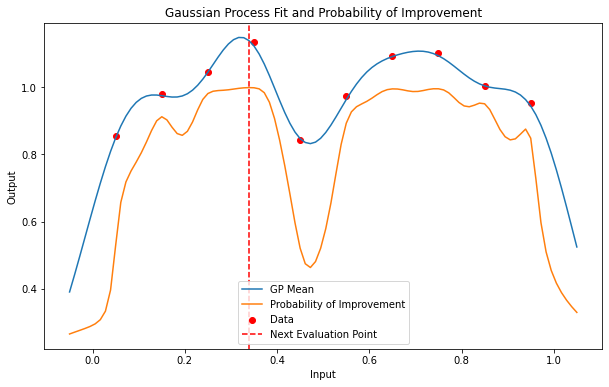

In [8]:
# Plot the GP fit, PoI values, and data points
plt.figure(figsize=(10, 6))
plt.plot(Xnew, mean, label='GP Mean')
plt.plot(Xnew, poi_values, label='Probability of Improvement')
plt.scatter(X, Y, c='red', label='Data')
plt.axvline(x=Xnew[np.argmax(poi_values)], color='r', linestyle='--', label='Next Evaluation Point')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Fit and Probability of Improvement')
plt.legend()
plt.show()
